<a href="https://colab.research.google.com/github/MarouaneMaatouk/ORCL-tweetClassification/blob/master/orcl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Tweets classification (Politics / Sports)*
***

Full name: MAATOUK MAROUANE

Account: ORCL-DS-APP420

Team:  PGX- DS-T420

---


In this notebook, we present the details of a binary classification problem on textual data.

The goal is to build a classifier able to tell if tweets are about *Sports* or *Politics*.
In order to achieve this, we'll procede in the following steps:





#### Plan:
* [**1 - Colab environment setup** ](#c1)
* [**2- Data preprocessing** ](#c2)
- - [**Loading the dataset** ](#c21)
- - [**Preparing the embedding vectors** ](#c22)
- - [**Handling missing keywords** ](#c23)
- - [**Preparing the data for the model** ](#c24)
* [**3- Model definition**](#c3)
- - [**Simple architecture** ](#c31)
- - [**Evaluation of different embeddings** ](#c32)
- - [**Error analysis** ](#c33)
- - [**Fine tuning** ](#c34)
- - [**Evaluation of different architectures** ](#c35)
- - [**Ensembling** ](#c36)
- - [**Data augmentation** ](#c37)
- - [**Final evaluation** ](#c38)
* [**4- Conclusion**](#c4)




---

###1- Env. setup
<a id="c1"></a>

In [0]:
from google.colab import files
file = files.upload()

In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Nov 28 08:32 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#Importing the data sets & embedding vectors
!kaggle competitions download -c deeptweets

!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


  0% 0.00/308k [00:00<?, ?B/s]
100% 308k/308k [00:00<00:00, 42.8MB/s]
  0% 0.00/886k [00:00<?, ?B/s]
100% 886k/886k [00:00<00:00, 58.8MB/s]
  0% 0.00/102 [00:00<?, ?B/s]
100% 102/102 [00:00<00:00, 89.7kB/s]
  0% 0.00/886k [00:00<?, ?B/s]
100% 886k/886k [00:00<00:00, 124MB/s]
100% 457M/458M [00:05<00:00, 83.8MB/s]
100% 458M/458M [00:05<00:00, 89.5MB/s]


In [4]:
!unzip glove-global-vectors-for-word-representation
!unzip wiki-news-300d-1M.vec.zip

!rm glove-global-vectors-for-word-representation.zip
!rm wiki-news-300d-1M.vec.zip

Archive:  glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [5]:
!ls

glove.6B.100d.txt  sample_submission.csv  x_dev.txt    Y_dev.txt
glove.6B.200d.txt  test.csv		  X_test.csv   Y_test.txt
glove.6B.50d.txt   train.csv		  x_test.txt   Y_train.txt
kaggle.json	   training.csv		  X_train.csv
sample_data	   X_dev.csv		  x_train.txt


In [6]:
!head glove.6B.50d.txt

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

***

### 2 - Data preprocessing
<a id="c2"></a>

In [7]:
from IPython.display import display, Image

import os
import re, string
import time, math, random
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm, tqdm_notebook as progress_bar

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')


import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Bidirectional, CuDNNLSTM ,LSTM, Dense, Activation,  Permute, Flatten, SpatialDropout1D, Dropout
from keras.layers import RepeatVector,Concatenate, Dot
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import adam


from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


#### Loading the dataset
<a id="c21"></a>

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


#Rows:  6525


Text(0.5, 1.0, 'Label distribution on the train set')

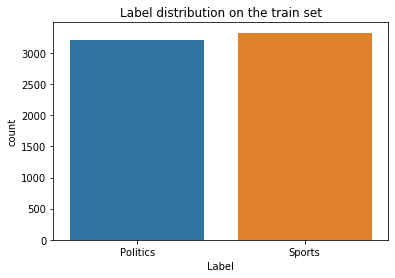

In [8]:
#Loading tweet dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
display(train.head())
print('#Rows: ', len(train))
plt = sns.countplot(train.Label)
plt.set_title('Label distribution on the train set')

The training data seems balenced number of labeled Politics data equals the number of labeled Sports data

#### Preparing the embedding vectors
<a id="c22"></a>

In [0]:
# Load the glove|fasttext pretrained vect

def load_embedding(i=50, emb_vect = 'glove'):
  if emb_vect == 'glove':
    file_name = 'glove.6B.'+ str(i) +'d.txt'  
  elif emb_vect == 'wiki-ft':
    file_name = "wiki-news-300d-1M.vec"
  elif emb_vect == 'crawl-ft':
    file_name = 'crawl-300d-1M.vec'
  else:
    raise Exception('Wrong filename')


  with open(file_name) as f:
    vocab = set()
    w2v = dict()
    ignore = stopwords.words('english') + list(string.punctuation)
    for line in tqdm(f):
      line_ = line.strip()
      wv = line.split()
      if wv[0] in ignore or not re.fullmatch('[a-zA-Z]+', wv[0]) or len(wv[0]) < 3:
        continue
      w = wv[0].lower()
      vocab.add(w)
      w2v[w] = np.array(wv[1:], dtype=float)

    w2v['PAD'] = np.zeros_like(w2v['king'])
    w2v['UNK'] = np.zeros_like(w2v['king'])
    w2v['UNK'][0] = 1
    w2v['EOS'] = np.zeros_like(w2v['king'])
    w2v['EOS'][1] = 1

    vocab.add("PAD")
    vocab.add("UNK")
    vocab.add("EOS")
    i2w = dict((i,c) for i, c in enumerate(w2v))
    w2i = dict((c,i) for i, c in enumerate(w2v))
    f.close()


  print('Vocab len = ', len(vocab))
  return vocab, w2v, i2w, w2i

In [0]:
def getToken(tweet):
  twt = TweetTokenizer(strip_handles=True, reduce_len=True)
  ignore = stopwords.words('english') 
  tweet = re.sub(r"[0-9]+-[0-9]+", 'score', tweet)
  tweet = re.sub(r"\n|\t|@|#|-", ' ', tweet)
  tweet = re.sub("'ve|'s|'re|'ll|'m|'d|^RT|^rt","",tweet)
  tokens = [token.lower()
            for token in twt.tokenize(tweet)
            if token.lower() not in ignore 
            and not re.match('http.*|www\..*|$\.com|goo\.gl.*',token)
            and not re.match('t.co.*', token)
            and re.match('[a-zA-Z]+', token)
            ]

  return tokens

In [0]:
tweet = 'Thank you Findout more about #RallyAgainstCancer 1-1 interview with @roscohutchins in latest2009 @andy_murray https://t.co/LvGKngSTql #AegonChampionships'	
print(getToken(tweet))

['thank', 'findout', 'rallyagainstcancer', 'score', 'interview', 'roscohutchins', 'latest', 'andy_murray', 'aegonchampionships']


In [0]:
#Adding '#.*' keyword to the embedding vectors similar to their label value
def add_tags(train, w2v):
  vocab = w2v.keys()
  tt = TweetTokenizer(strip_handles=True, reduce_len=True)
  h_sports = []
  h_politics = []
  for i, r in tqdm(train.iterrows()):
    tweet = r.TweetText
    h_tokens = re.findall("#\w+", tweet)
    for token in h_tokens:
      token = re.sub(r'#','', token)
      token = token.lower()
      if token not in vocab:
        if r.Label == 'Sports':
          h_sports.append(token)
        else:
          h_politics.append(token)

  tag_sports = Counter(h_sports).most_common(20)
  tag_politics = Counter(h_politics).most_common(20)
  print()
  print('Sports # freq ',tag_sports)
  print('Politics # freq ',tag_politics)

  for tag, _ in tag_sports:
      w2v[tag] = w2v['sport']
  for tag, _ in tag_politics:
      w2v[tag] = w2v['politic']

  return w2v

In [0]:
#Adding the most famous accounts

def add_top_accs(train, w2v):
  sports_accounts = []
  politics_accounts = []
  for i, r in tqdm(train.iterrows()):
    tweet = r.TweetText
    accs = re.findall("@\w+", tweet)  
    if r.Label == "Sports":
      sports_accounts.extend(accs)
    else:
      politics_accounts.extend(accs)
          
  # We'll add the top 20 accs
  sports_acc_counts = Counter(sports_accounts)
  politics_acc_counts = Counter(politics_accounts)
  sports_acc_freq = sports_acc_counts.most_common(20)
  politics_acc_freq = politics_acc_counts.most_common(20)

  print()
  print('Sports top accounts # freq ',sports_acc_freq)
  print('Politics top accounts ',politics_acc_freq)

  for a, _ in politics_acc_freq:
    a = re.sub('@', '', a).lower()
    w2v[a] = w2v['politic']
  for a, _ in sports_acc_freq:
    a = re.sub('@', '', a).lower()
    w2v[a] = w2v['sport']
  return w2v

In [0]:
#Adding most frequent/used keywords 
def add_top_keywords(train, w2v):
  vocab = w2v.keys()
  sports = []
  politics = []
  for i, r in tqdm(train.iterrows()):
    tweet = r.TweetText
    label = r.Label
    if label == 'Sports':
      sports.extend(getToken(tweet))
    else:
      politics.extend(getToken(tweet))
  

  sports_w_freq = Counter(sports).most_common(40)
  politics_w_freq = Counter(politics).most_common(40)

  print(sports_w_freq)
  print(politics_w_freq)

  W_ADDED = 0
  for w, _ in politics_w_freq:  
    if w not in vocab:
      w2v[w] = w2v['politic']
      W_ADDED += 1
  for w, _ in sports_w_freq:
    if w not in vocab:
      w2v[w] = w2v['sport']
      W_ADDED += 1
  print('#W_ADDED:', W_ADDED)
  return w2v

In [0]:
#Updates after w2v modifications
def get_emb(train, i=50, emb_vect = 'glove'):
  _, w2v, _, _ = load_embedding(i, emb_vect)
  w2v = add_tags(train, w2v)
  w2v = add_top_accs(train, w2v)
  w2v = add_top_keywords(train, w2v)
  vocab = w2v.keys()
  i2w = dict((i,c) for i, c in enumerate(w2v))
  w2i = dict((c,i) for i, c in enumerate(w2v))
  return vocab, w2v, i2w, w2i

In [15]:
vocab, w2v, i2w, w2i = get_emb(train)

400000it [00:05, 72439.66it/s]
1038it [00:00, 10375.80it/s]

Vocab len =  316950


6525it [00:00, 10072.68it/s]
1007it [00:00, 10063.22it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6525it [00:00, 9885.21it/s] 
220it [00:00, 2193.94it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6525it [00:02, 2237.33it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

#### Handling missing keywords
<a id="c23"></a>


100%|██████████| 6525/6525 [00:01<00:00, 3675.75it/s]



Missing ratio:  0.21956435643564357


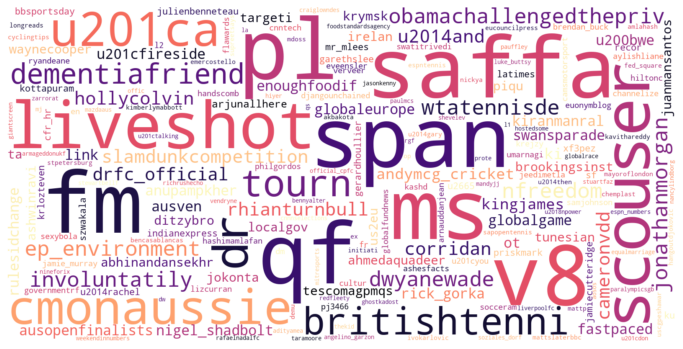

Missing keyword frequency: 
[('obamachallengedthepriv', 1), ('involuntatily', 1), ('ep_environment', 1), ('dwyanewade', 1), ('nfreedom', 1), ('jonathanmorgan', 1), ('wtatennisde', 1), ('slamdunkcompetition', 1), ('cameronvdd', 1), ('u2014and', 1)]


In [16]:
#Check ratio of missing tokens
import matplotlib.pyplot as plt

missing_tokens = set()
t_tokens = set()

for tweet in tqdm(train.TweetText):
  tokens = getToken(tweet)
  for token in tokens:
    t_tokens.add(token)
    if token not in vocab:
      missing_tokens.add(token)
print()
print("Missing ratio: ", len(missing_tokens) / len(t_tokens))

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(" ".join(missing_tokens)) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()
print('Missing keyword frequency: ')
print(Counter(missing_tokens).most_common(10))

In [17]:
# Removing rows with no information
ind2drop = []
for i, r in train.iterrows():
  tokens = getToken(r.TweetText)
  if len(tokens) == 0 or all(token not in vocab for token in tokens):
    ind2drop.append(i)    

display(train.iloc[ind2drop])      
train = train.drop(index=ind2drop)
print("#Rows removed: ", len(ind2drop))

print(ind2drop)

,TweetId,Label,TweetText
124,306345853000499200,Politics,'@MandeepBajwa :-) @nitingokhale @mdiirfankhan'
146,303631987988639744,Sports,'@89vivienne :-('
391,306300230322765824,Sports,'@mikedc73 :-)'
666,306086688223010816,Politics,'@Greyllusionist :-)'
715,306716488956514304,Sports,'@fringbird ha!'
928,300450714331787264,Sports,'@IamCRK Hi there!'
1179,34145979036860416,Sports,'@BarryHGreen @channelnine *facepalm*'
1202,305994196353953792,Politics,'@SwatiTrivedi :)'
1304,306777460379365376,Sports,'@procdoc3 #eachtotheirown ;-)'
1447,305386161210286080,Politics,'@abbasnasir59 that too :)'


#Rows removed:  35
[124, 146, 391, 666, 715, 928, 1179, 1202, 1304, 1447, 1689, 1810, 1824, 2339, 3318, 3334, 3529, 3751, 3805, 3859, 4264, 4292, 4596, 4598, 4613, 4654, 4786, 4816, 5178, 5419, 5496, 5570, 6018, 6227, 6493]


In [222]:
# Somme keywords may be ill writen 
# We'll try to match the correct words using the levenshtein distance (later we'll use also stemming)
# To avoid looking in the entire vocab (len = 300k) we'll break it down using the first letter

keys_lookup = dict()
letters = string.ascii_letters[:26]
for l in letters:
  keys_lookup[l] = list()  
  for key, ind in w2i.items():    
    if re.match(r'^'+l+'.*', key):
      keys_lookup[l].append(key)
     
len(keys_lookup['a']) 


def sim_word_ind(word, min_dist = 3):  
  word = re.sub(r'(.)\1{2,}', r'\1\1', word) # make chars repeatition at most 2 times  
  
  sim_word_w = 'UNK'
  lookup_ls = keys_lookup[word[0]]
  length = len(lookup_ls)
  n_iter_sample = random.sample(range(0, length), int(length/2)) # for faster computation

  for i in n_iter_sample:  
    w = lookup_ls[i]      
    if np.abs(len(w) - len(word)) > min_dist:
      continue
    dist = nltk.edit_distance(word, w)
    if dist < min_dist:
      min_dist = dist
      sim_word_w = w
      break
    
  return w2i[sim_word_w], sim_word_w

sim_word_ind('buyere', min_dist = 2)


(4053, 'buyers')

#### Preparing the data for the model
<a id="c24"></a>

In [0]:
# Converting the sentences into array of indices
def sentences2indice(X, w2i, vocab, MAXLEN):
  """
  X: dataframe
  w2i: word to index dictionnary
  vocab: embedding vector vocabulary
  MAXLEN: required length of the sentences
  """
  start_time = time.time()
  m = X.shape[0]
  v = np.full((m, MAXLEN),fill_value=w2i['PAD'], dtype=int)
  ps = PorterStemmer()
  
  for i in tqdm(range(m)):
    j = 0
    tokens = getToken(X[i])  
    for  w in tokens:
      if w in vocab:
        v[i, j] = w2i[w]
      elif ps.stem(w) in vocab:
        v[i, j] = w2i[ps.stem(w)]      
      else:  
        sim_w_ind, _ = sim_word_ind(w,3)
        v[i, j] = sim_w_ind

      j += 1

    v[i,j] = w2i['EOS']
  print("- %s seconds -" % (time.time() - start_time))

  return v

In [0]:
# After exec miss-labeled section in (3) error analysis
MAXLEN = 25 
lb = LabelEncoder()

labels = lb.fit_transform(train.Label)

X_train, X_dev, Y_train, Y_dev = train_test_split(train.TweetText, labels, test_size = .3 , random_state = 1, shuffle = True)
X_dev, X_test , Y_dev, Y_test = train_test_split(X_dev, Y_dev, test_size = .4 , random_state = 1, shuffle = True)

x_train = sentences2indice(np.array(X_train), w2i, vocab, MAXLEN)
x_dev = sentences2indice(np.array(X_dev), w2i, vocab, MAXLEN)
x_test = sentences2indice(np.array(X_test), w2i, vocab, MAXLEN)

test_tweets = sentences2indice(np.array(test.TweetText), w2i, vocab, MAXLEN)

### 3 - Model definition
<a id="c3"></a>

#### Simple architecture
<a id="c31"></a>

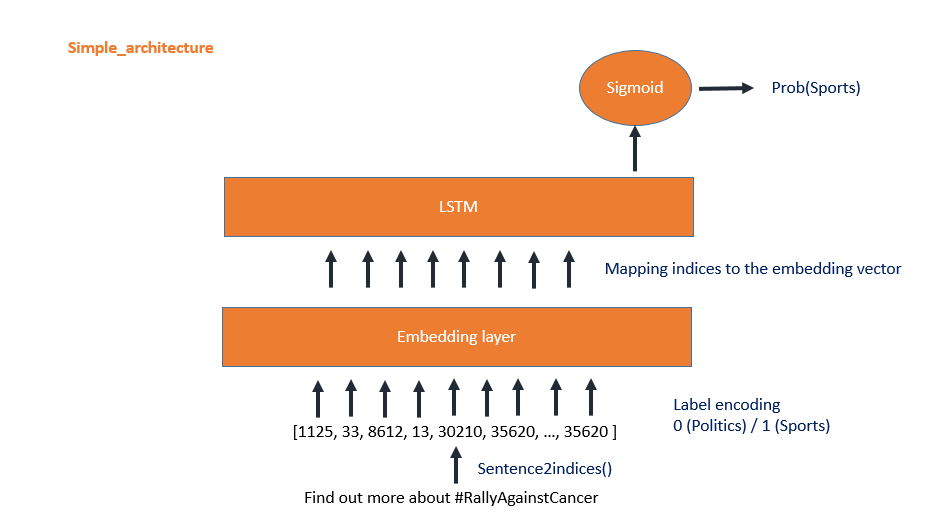

In [0]:
Image('simple_achitecture.png')

In [0]:
def emb_mat():
  emb_dim = w2v['king'].shape[0]
  vocab_len = len(vocab) + 1

  emb_matrix = np.zeros((vocab_len, emb_dim))

  for w, i in w2i.items():
    emb_matrix[i,:] = w2v[w]
    
  return emb_matrix

In [0]:
def pretrained_emb():
  
  emb_matrix = emb_mat()  
  emb_layer = Embedding(emb_matrix.shape[0], emb_matrix.shape[1], trainable = False)
  emb_layer.build((None,))
  emb_layer.set_weights([emb_matrix])

  return emb_layer


In [0]:
def TweetModel(input_shape = (25,), n_a = 128, lr = 0.01, DROPOUT = 0, R_DROPOUT = 0):

  sentence_ind = Input(shape = input_shape, dtype = np.int32)
  
  emb_layer = pretrained_emb() 
  emb_layer = emb_layer(sentence_ind)

  lstm = LSTM(n_a, dropout = DROPOUT, recurrent_dropout = R_DROPOUT)(emb_layer)

  output = Dense(1, activation = 'sigmoid')(lstm)

  model = Model(inputs = [sentence_ind], outputs = [output])
  
  opt = adam(lr= lr, decay = lr/10)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])

  return model  

In [0]:
tweetModel = TweetModel((MAXLEN,))
tweetModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 25, 100)           31703400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 31,820,777
Trainable params: 117,377
Non-trainable params: 31,703,400
_________________________________________________________________


In [0]:
history50d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1)

Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 21s 5ms/step - loss: 0.5326 - acc: 0.7367 - val_loss: 0.5737 - val_acc: 0.6832
Epoch 2/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.2622 - acc: 0.8994 - val_loss: 0.1972 - val_acc: 0.9307
Epoch 3/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.1442 - acc: 0.9461 - val_loss: 0.1749 - val_acc: 0.9384
Epoch 4/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.1063 - acc: 0.9604 - val_loss: 0.1594 - val_acc: 0.9289
Epoch 5/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.0753 - acc: 0.9703 - val_loss: 0.1409 - val_acc: 0.9426
Epoch 6/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.0498 - acc: 0.9824 - val_loss: 0.1968 - val_acc: 0.9358
Epoch 7/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.0315 - acc: 0.9888 - val_loss: 0.1886 - val_acc: 0.9401
Epoch 8

Text(0, 0.5, 'loss')

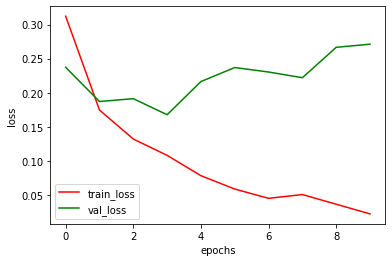

In [0]:
plt = sns.lineplot(y=history50d.history['loss'], x = np.arange(10), label = 'train_loss', color = 'r')
sns.lineplot(y=history50d.history['val_loss'], x = np.arange(10), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
# Evaluate on our test set
tweetModel.evaluate(x_test, Y_test)

779/779 [==============================] - 0s 620us/step


[0.28386173884124904, 0.9293966623876765]

Although the accuracy of the dev set is still high,
this plot shows clearly that we are overfitting the training data.

We can use early stopping and dropout to try to fix it. The downside we may overfit the dev set (To check it we have our custom test set)


In [0]:
earlyStopping = EarlyStopping(monitor = 'val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')
tweetModel = TweetModel((MAXLEN,), DROPOUT = 0.5)
history50d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [earlyStopping])

Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.6258 - acc: 0.6443 - val_loss: 0.5526 - val_acc: 0.7586
Epoch 2/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.4688 - acc: 0.8021 - val_loss: 0.2825 - val_acc: 0.8964
Epoch 3/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.2276 - acc: 0.9080 - val_loss: 0.2117 - val_acc: 0.9101
Epoch 4/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.1628 - acc: 0.9359 - val_loss: 0.2007 - val_acc: 0.9170
Epoch 5/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.1266 - acc: 0.9525 - val_loss: 0.1693 - val_acc: 0.9255
Epoch 6/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.0980 - acc: 0.9615 - val_loss: 0.1851 - val_acc: 0.9110


Text(0, 0.5, 'loss')

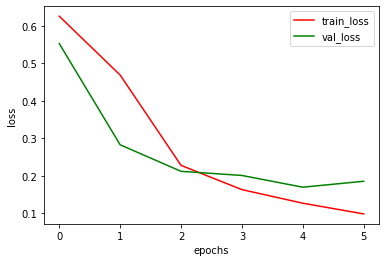

In [0]:
train_loss = history50d.history['loss']
val_loss = history50d.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
ypred = tweetModel.predict(test_tweets, batch_size=20)
  Label = []
  for ys in ypred:
    if ys > .5:
      Label.append("Sports")
    else:
      Label.append("Politics")
    
  Label= pd.DataFrame(Label, columns=["Label"])
  sub = pd.concat([test.TweetId, Label], axis = 1)
  print(sub)

  !rm sub.csv
  sub.to_csv("sub.csv", index=False)
  !kaggle competitions submit -c deeptweets -f sub.csv -m ""

Problem solved ?

Too early to celebrate, there's a somme error analysis and hyperparams tuning, but we'll leave this for a latter section

#### Evaluation of different embeddings
<a id="c32"></a>

Before jumping into the error analysis, it may be interesting to check the results using the different embeddings (Glove: 100d, 200d / FastText: wikipedia, crawl )

In [0]:
print('------------ glove 100dim------------')
vocab, w2v, i2w, w2i = get_emb(train, i = 100)
tweetModel = TweetModel((MAXLEN,))
history100d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)
print('------------ glove 200dim------------')
vocab, w2v, i2w, w2i = get_emb(train, i = 200)
tweetModel = TweetModel((MAXLEN,))
history200d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)  
print('------------ wiki-fasttext------------')
vocab, w2v, i2w, w2i = get_emb(train, emb_vect='wiki-ft')
tweetModel = TweetModel((MAXLEN,))
historywikift = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)
print('------------ crawl-fasttext------------')
vocab, w2v, i2w, w2i = get_emb(train, emb_vect='crawl-ft')
tweetModel = TweetModel((MAXLEN,))
historycrawlft = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)


3219it [00:00, 32185.04it/s]

------------ glove 50dim------------
------------ glove 100dim------------


400000it [00:10, 39692.78it/s]
916it [00:00, 9155.93it/s]

Vocab len =  316950


6490it [00:00, 9449.35it/s]
966it [00:00, 9655.57it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6490it [00:00, 9575.42it/s]
216it [00:00, 2153.57it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2090.72it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

2371it [00:00, 23704.54it/s]

------------ glove 200dim------------


400000it [00:17, 22964.05it/s]
955it [00:00, 9547.41it/s]

Vocab len =  316950


6490it [00:00, 9075.51it/s]
946it [00:00, 9456.15it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6490it [00:00, 9375.09it/s]
215it [00:00, 2141.99it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2076.67it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

1538it [00:00, 15377.70it/s]

------------ wiki-fasttext------------


999995it [00:56, 17609.81it/s]
965it [00:00, 9644.67it/s]

Vocab len =  577359


6490it [00:00, 9557.39it/s]
968it [00:00, 9672.15it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10), ('jobsovercuts', 9)]


6490it [00:00, 9261.81it/s]
219it [00:00, 2183.51it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2087.70it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

1714it [00:00, 17136.87it/s]

------------ crawl-fasttext------------


999995it [00:57, 17245.12it/s]
983it [00:00, 9824.62it/s]

Vocab len =  577359


6490it [00:00, 9614.39it/s]
920it [00:00, 9191.57it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10), ('jobsovercuts', 9)]


6490it [00:00, 9113.78it/s]
207it [00:00, 2069.02it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2055.08it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

Loss/Acc of different embedding vectors


Text(0, 0.5, 'acc')

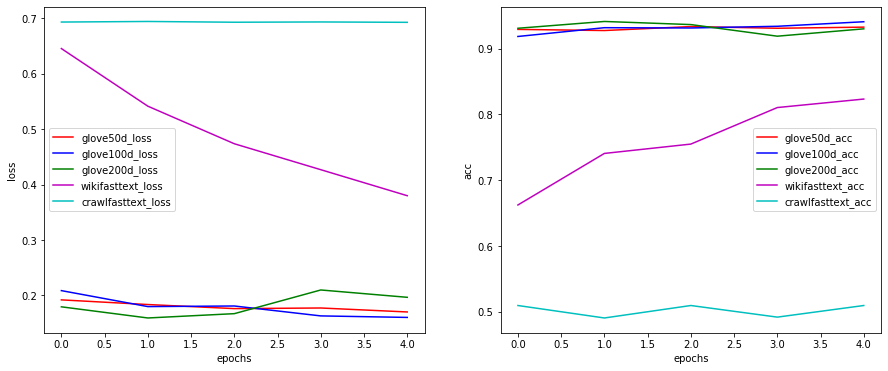

In [0]:
l1 = history50d.history['val_loss']
l2 = history100d.history['val_loss']
l3 = history200d.history['val_loss']
l4 = historywikift.history['val_loss']
l5 = historycrawlft.history['val_loss']


acc1 = history50d.history['val_acc']
acc2 = history100d.history['val_acc']
acc3 = history200d.history['val_acc']
acc4 = historywikift.history['val_acc']
acc5 = historycrawlft.history['val_acc']



fig, ax = plt.subplots(1, 2, figsize = (6,6))
fig.set_size_inches(15,6)

length = np.arange(len(l1))

print('Loss/Acc of different embedding vectors')

sns.lineplot(y= l1, x = length, label = 'glove50d_loss', color = 'r', ax= ax[0])
sns.lineplot(y= l2, x = length, label = 'glove100d_loss', color = 'b',  ax= ax[0])
sns.lineplot(y= l3, x = length, label = 'glove200d_loss', color = 'g', ax= ax[0])
sns.lineplot(y= l4, x = length, label = 'wikifasttext_loss', color = 'm', ax= ax[0])
sns.lineplot(y= l5, x = length, label = 'crawlfasttext_loss', color = 'c', ax= ax[0])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

sns.lineplot(y= acc1, x = length, label = 'glove50d_acc', color = 'r', ax= ax[1])
sns.lineplot(y= acc2, x = length, label = 'glove100d_acc', color = 'b',  ax= ax[1])
sns.lineplot(y= acc3, x = length, label = 'glove200d_acc', color = 'g', ax= ax[1])
sns.lineplot(y= acc4, x = length, label = 'wikifasttext_acc', color = 'm', ax= ax[1])
sns.lineplot(y= acc5, x = length, label = 'crawlfasttext_acc', color = 'c', ax= ax[1])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('acc')

In [22]:
# The glove 100d seems having the best performance
vocab, w2v, i2w, w2i = get_emb(train, i = 100)

400000it [00:08, 45815.09it/s]
919it [00:00, 9184.78it/s]

Vocab len =  316950


6490it [00:00, 9651.73it/s]
1024it [00:00, 10235.59it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6490it [00:00, 9722.38it/s] 
224it [00:00, 2239.12it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:02, 2255.35it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

#### Error analysis
<a id="c33"></a>

,TweetText,predLabel,Label
3600,'What causes @bryanbrothers to say @ryanharrison92 is tardy &amp; @bryanbros to dub @MicaelaBryan a diva? Read our Q&amp;A! http://t.co/dw8b2EaE #atp',Politics,Sports
4903,"'RT @umarnagi: Look at this @ESPNcricinfo app for windows 8, and you\u2019ll fall in love. Beautiful! \U0001f60d http://t.co/pGnUn9Vh'",Politics,Sports
11,@KHANNISARA thanks. Won't respond to their rubbish,Sports,Politics
483,'@mfjfullpo very nice! I shall do!',Politics,Sports
4083,'RT @AEGONClassic: We\u2019re really excited to announce that Help Harry Help Others @harry_moseley is the official charity partner for the to ...',Politics,Sports
...,...,...,...
700,RT @Joydas: Just another Day RT @sardesairajdeep: If rest of india was denied newspapers 3 days we'd call it emergency! What should kash ...,Politics,Sports
5666,'Brits including @annekeothavong &amp; @JamesWardtennis are in action this week. Find the latest - http://t.co/uhZOaWCEih http://t.co/YhxcJGsExC',Politics,Sports
4431,'@hiyer hey you. Thanks. I wept myself through that one. :) hugs',Sports,Politics
1315,'RT @swish41: Noleeee',Politics,Sports


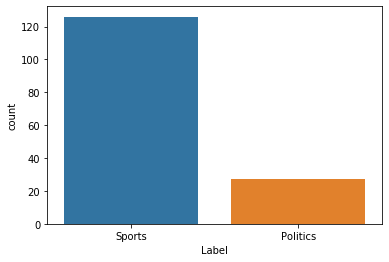

In [0]:
#Checking errors in the train set
lb = LabelEncoder()
lb.fit(train.Label)

y_pred = tweetModel.predict(x_train, batch_size= 20)
label = []

for y in y_pred:
  if y > .5:
    label.append("Sports")
  else:
    label.append("Politics") 

y_train = pd.Series(lb.inverse_transform(Y_train.astype(int)), name = 'Label', index = X_train.index)

label = pd.DataFrame(label, columns=["predLabel"], index = X_train.index)
res = pd.concat([X_train, label, y_train], axis=1)
res = res.loc[res.predLabel != res.Label]
pd.set_option('display.max_colwidth', -1)


display(res)
sns.countplot(res.Label)

,TweetText,Label,predLabel
21,"'Sadly, Sharmila Tagore could not come as she was ailing...'",Sports,Politics
2307,'Not sure what to look for at this year\u2019s NFL Combine? Here\u2019s a handy guide on what to expect -&gt; http://t.co/UbvdWymC (via @ClaytonESPN)',Sports,Politics
3055,'@SAMI_hadyh thanks.',Politics,Sports
6140,"'Mention this tweet for a free point! Quiz tonight Hampshire Hotel, Sydney, 7pm. Run by us!! details - http://on.fb.me/hlvOEG'",Sports,Politics
1281,#WheresJaimie - see if you can guess which ground Jaimie was at this week... Don't forget the hashtag http://t.co/rGy1icYI,Sports,Politics
...,...,...,...
999,'RT @TennisFndation: Keep up-to-date with all the latest news &amp; results as lots of our Paralympians are in action at #NorthWestChalle ...',Sports,Politics
2734,"'@sidin Olive (Bandra or Mahalaxmi), Indigo terrace (Colaba)...'",Sports,Politics
1897,'@DriveDontDie yeps. Seen both seasons',Politics,Sports
198,"'40% off all nutrition at the Official Maximuscle Shop for 2 days, plus free delivery! 25-26 February only http://t.co/Ka1EP1oK9h'",Sports,Politics


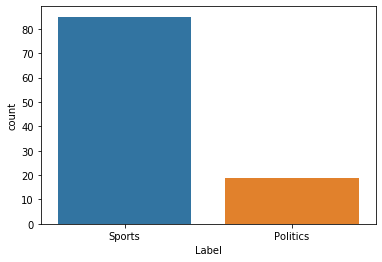

In [0]:
# #Checking errors in the dev set
y_pred = tweetModel.predict(x_dev, batch_size=20)
label = []

for y in y_pred:
  if y > .5:
    label.append("Sports")
  else:
    label.append("Politics")
  
label= pd.DataFrame(label, index = X_dev.index, columns=["predLabel"])
y_dev = pd.Series(lb.inverse_transform(Y_dev.astype(int)), name = 'Label', index = X_dev.index)
res = pd.concat([X_dev,  y_dev, label], axis=1)
res = res.loc[res.predLabel != res.Label]
pd.set_option('display.max_colwidth', -1)

display(res)
sns.countplot(res.Label)

The model is not doing great on the sports prediction, we can see a lot of ambiguious examples where even humans wouldn't get it right.


Also it's clear that there is somme wrong labels are assigned to the data

In [0]:
#Label mismatch correction

# # After multiple iteration using different settings and random states,
# # We've noticed multiple data having the wrong labels
# # Note that the previous results happens after this "correction"

"""
This sentences should be sports instead of politics
  'Congrats to Brandt Snedeker on his win of the tour championship and FedEx Cup. He is a class act.'	5517
  'Congrats to the Detroit @Tigers on making it to the World Series! Part of the heart and soul of Detroit.': 1021
  ?'Chat with @angelahucles, former @ussoccer_wnt member, 2x Olympic gold medalist &amp; World Cup athlete 2/21 @CONX: http://t.co/lJJHxkiMOC #LGBT'	 
  'Cricket fever in cambodia http://t.co/fu2GUtmx' 5314
  'Our team will be blogging regularly from the BCIM Car Rally on our blog: http://t.co/bWg0NWOh'	 4682
  1043	'Meeting with representatives of student sports clubs: funding of sports and physical training at universities http://t.co/DiNwdCdq'
  5421	'Players like Jermaine Jones make #Football more popular in the US. http://t.co/E39aIHNf @USConGenNRW #Schalke04
  290	'Players like Jermaine Jones introduce more #US fans to the beautiful game. http://t.co/E39aIHNf #football @SportsDiplomacy'
  3004 @PeculiarBlend @HRCIndia will be in Delhi. Who's playing and in which city?	sports
  4182 'Players like Jermaine Jones introduce more #US fans to the beautiful game. http://t.co/E39aIHNf #football @usbotschaft'	


This sentences should be politics instead of sports  
  'RT @ranjona: Time to confront child sex abuse: my column for Mid-Day @mid_day @SachinKalbag http://t.co/UkCSZLlnI8'	
  '@rossgrosvenor Hi Ross - yes, important to remember others so we mentioned journalists, club staff, crew &amp; passengers also lost their lives'	:6282
  'Foxes support mental health campaign http://t.co/cyyhJylZcz' :3415
  According to @Klout, @FollowTheAshes's Klout score is 25. How influential are you? http://t.co/2DBiECf	:4720
  'RT @amlahash: One of the challenges of life is addressing our own hypocrisy and also.. handling the hypocrisy of others.'	1634
  4766	Happy President's Day! -&gt; http://t.co/ycLQ9Fep
  2492	'RT @abdullah_omar: There is NO ban on newspapers in Kashmir. Papers are choosing not to print because restrictions make delivery of news ...'
  5086	'RT @BDUTT: Newspapers make a return to the stands in Kashmir valley after four days as a partial lifting of restrictions begins'	
  1634	'RT @amlahash: One of the challenges of life is addressing our own hypocrisy and also.. handling the hypocrisy of others.'	 
  2564	'Reistrations open for #AusGP Driving Careers, Driving Success seminars. Inspire next gen of engineers &amp; manufacturers http://t.co/Fa1nxV0ulZ
  1434	@allsopp162 @kashd23 it's a recognition that recreational drugs are used by people in society, but we of course do not condone it	
  

This sentence label was clearly determined by @PaulRyanVP a politician
  'Sign up for your chance to score a guitar signed by @KidRock and @PaulRyanVP http://t.co/XztAFdep' : 267
  
"""

p2s_inds = [5517, 5314, 1021, 4682, 1043, 5421, 290, 3004, 4182]
train.loc[p2s_inds, 'Label'] = "Sports"


s2p_inds = [ 2746, 267, 6282, 3415, 4720, 1634, 4766, 2492, 5086, 2564, 1434]
train.loc[s2p_inds, 'Label'] = "Politics"



#### Fine-Tuning
<a id="c34"></a>

In [0]:
#Defining the hyperparams search space

# Hyperparams:
## lstm activation dim = n_a, learning_rate = lr, epochs, DROPOUT,  R_DROPOUT
## The decay as rule of thumb = lr/10

batch_size = [32, 64 ,128]
epochs = [5, 10]
lr = [0.001, 0.01]

n_a = [32, 64, 128]
DROPOUT = [0, 0.2, 0.5]
R_DROPOUT = [0, 0.2]

# we have 216 combinaisons we'll only explore a random subset of 10

param_grid = dict(    
    batch_size = batch_size,
    epochs = epochs,
    lr = lr,
    n_a = n_a,    
    DROPOUT = DROPOUT,
    R_DROPOUT = R_DROPOUT
        
)


#Hyperparam tuning
model = KerasClassifier(build_fn = TweetModel, verbose = 1)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter = 10, cv= 3, verbose = 100)
tweets = np.concatenate([x_train, x_dev])
labels = np.concatenate([y_train, y_dev])
tweetModel_result = grid.fit(tweets, labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_a=128, lr=0.01, epochs=5, batch_size=32, R_DROPOUT=0.2, DROPOUT=0.2 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
3807/3807 [==============================] - 14s 4ms/step - loss: 0.5342 - acc: 0.7560
Epoch 2/5
3807/3807 [==============================] - 7s 2ms/step - loss: 0.3164 - acc: 0.8863
Epoch 3/5
3807/3807 [==============================] - 8s 2ms/step - loss: 0.2116 - acc: 0.9241
Epoch 4/5
3807/3807 [==============================] - 8s 2ms/step - loss: 0.1678 - acc: 0.9370
Epoch 5/5
1904/1904 [==============================] - 4s 2ms/step
[CV]  n_a=128, lr=0.01, epochs=5, batch_size=32, R_DROPOUT=0.2, DROPOUT=0.2, score=0.935, total=  56.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.8s remaining:    0.0s
[CV] n_a=128, lr=0.01, epochs=

In [0]:
tweetModel_result.best_params_

{'DROPOUT': 0.2,
 'R_DROPOUT': 0,
 'batch_size': 32,
 'epochs': 10,
 'lr': 0.001,
 'n_a': 64}

In [0]:
tweetModel_result.best_estimator_.model.evaluate(x_test, Y_test)

779/779 [==============================] - 6s 8ms/step


[0.18563604434241993, 0.9409499361977192]

In [0]:
tweetModel_result.best_estimator_.model.save_model("simple_model_tuned.h5")

In [0]:
tweetModel = load_model('simple_model_tuned.h5')

#### Evaluation of different architectures
<a id="c35"></a>

So far we don't suffer from high bias, but trying more complex architectures will certainly help us capture more complicated features.



*   Deeper lstm
*   CNN-LSTM
*   With attention layer



In [0]:
#Stacked LSTM
def StackedLSTM_TweetModel(n_a, n_l, DROPOUT, S_DROPOUT , input_shape =  (25,)):  

  sentence_ind = Input(shape = input_shape)  
  emb_layer = pretrained_emb()
  emb_layer = emb_layer(sentence_ind)
  emb_layer = SpatialDropout1D(S_DROPOUT)(emb_layer)

  lstm = Bidirectional(CuDNNLSTM(n_a, name = 'LSTM-1', return_sequences = True))(emb_layer)
  lstm = Dropout(DROPOUT)(lstm)
  lstm = CuDNNLSTM(n_a, name = 'LSTM-2', return_sequences = True)(lstm)
  lstm = Dropout(DROPOUT)(lstm)
  lstm = CuDNNLSTM(n_a, name = 'LSTM-3')(lstm)
  lstm = Dropout(DROPOUT)(lstm)
      
  X = Dense(n_l, activation="relu")(lstm)  
  X = Dropout(DROPOUT)(X)    

  output = Dense(1, activation = "sigmoid", name = 'output')(X)
  
  model = Model(inputs=sentence_ind, outputs= output, name = "StackedLSTM_TweetModel")

  opt = adam(lr=0.001, decay = 0.0001)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])
  
  return model

In [0]:
stackedLSTM_TweetModel = StackedLSTM_TweetModel(64, 32, 0.2, 0, 0.2, (MAXLEN,))
stackedLSTM_TweetModel.summary()

Model: "StackedLSTM_TweetModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 25, 100)           31703400  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 25, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 128)           84992     
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
LSTM-2 (CuDNNLSTM)           (None, 25, 64)            49664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 64) 

In [0]:
#Instead of early stopping we'll let our model train longer and save the best result 
ckpt = ModelCheckpoint('stackedLSTM_TweetModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
history1 = stackedLSTM_TweetModel.fit(x_train, Y_train, batch_size= 32, epochs = 15, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [ckpt])

Train on 4543 samples, validate on 1168 samples
Epoch 1/15
4543/4543 [==============================] - 25s 5ms/step - loss: 0.2745 - acc: 0.8866 - val_loss: 0.1864 - val_acc: 0.9255

Epoch 00001: val_loss improved from inf to 0.18645, saving model to stackedLSTM_TweetModel.h5
Epoch 2/15
4543/4543 [==============================] - 5s 1ms/step - loss: 0.1831 - acc: 0.9291 - val_loss: 0.1544 - val_acc: 0.9298

Epoch 00002: val_loss improved from 0.18645 to 0.15444, saving model to stackedLSTM_TweetModel.h5
Epoch 3/15
4543/4543 [==============================] - 5s 1ms/step - loss: 0.1739 - acc: 0.9276 - val_loss: 0.1625 - val_acc: 0.9289

Epoch 00003: val_loss did not improve from 0.15444
Epoch 4/15
4543/4543 [==============================] - 5s 1ms/step - loss: 0.1479 - acc: 0.9370 - val_loss: 0.1578 - val_acc: 0.9341

Epoch 00004: val_loss did not improve from 0.15444
Epoch 5/15
4543/4543 [==============================] - 5s 1ms/step - loss: 0.1426 - acc: 0.9375 - val_loss: 0.1509 -

Text(0, 0.5, 'loss')

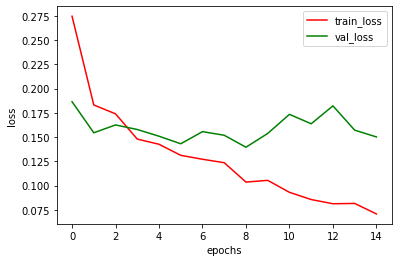

In [0]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
stackedLSTM_TweetModel = load_model('stackedLSTM_TweetModel.h5')

loss, acc = stackedLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = stackedLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 7s 6ms/step
dev evaluation: 0.13954301977096356  /  0.9375
779/779 [==============================] - 0s 337us/step
test evaluation: 0.1636033195509684  /  0.9383825421027255


---

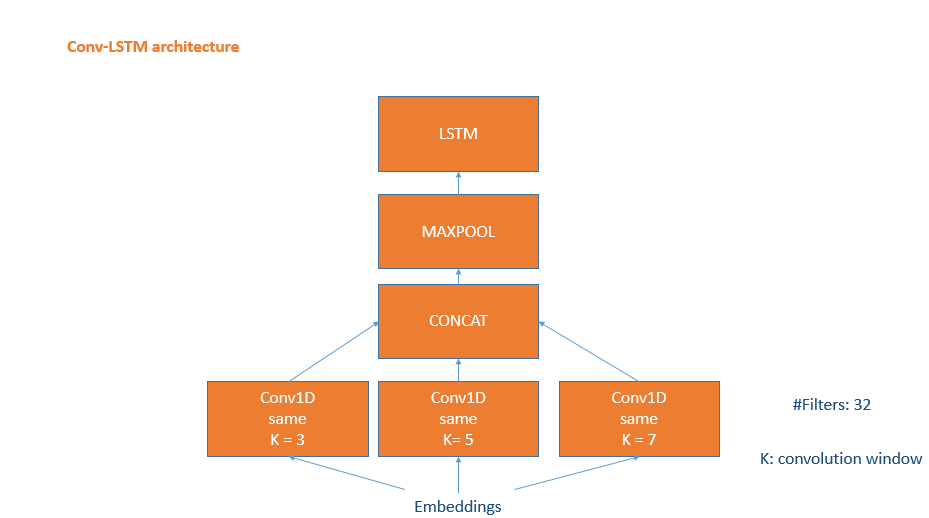

In [0]:
Image('convlstm_architecture.PNG')

In [0]:
#Conv-LSTM architecture

def CNNLSTM_TweetModel(n_a, n_l, DROPOUT, S_DROPOUT,  input_shape =  (25,)):
  
  sentence_ind = Input(shape = input_shape)
  
  emb_layer = pretrained_emb()
  emb_layer = emb_layer(sentence_ind)
  emb_layer = SpatialDropout1D(S_DROPOUT)(emb_layer)  

  conv1 = Conv1D(filters = 32, kernel_size = 3, padding='same', activation='relu')(emb_layer)  
  conv2 = Conv1D(filters = 32, kernel_size = 5, padding='same', activation='relu')(emb_layer)  
  conv3 = Conv1D(filters = 32, kernel_size = 7, padding='same', activation='relu')(emb_layer)  
  
  concat = concatenate([conv1, conv2, conv3])
  pool = MaxPooling1D(pool_size=2)(concat)
  
  lstm = Bidirectional(CuDNNLSTM(n_a,  return_sequences = True, name = 'LSTM-1'))(pool)
  X = Dropout(DROPOUT)(lstm)
  X = Flatten()(X)

  X = Dense(n_l, activation="relu")(X)  
  X = Dropout(DROPOUT)(X)    

  output = Dense(1, activation = "sigmoid", name = 'output')(X)
    
  model = Model(inputs=sentence_ind, outputs = output, name = "CNNLSTM_TweetModel")
  
  opt = adam(lr=0.001, decay = 0.0001)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])

  return model

In [0]:
cnnLSTM_TweetModel = CNNLSTM_TweetModel(64, 32, 0.5, 0.2, (MAXLEN,))
cnnLSTM_TweetModel.summary()


Model: "CNNLSTM_TweetModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 100)      31703400    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 25, 100)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 32)       9632        spatial_dropout1d_3[0][0]        
________________________________________________________________________________

In [0]:
ckpt = ModelCheckpoint('cnnLSTM_TweetModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

history2 = cnnLSTM_TweetModel.fit(x_train, Y_train, batch_size= 32, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [ckpt])

Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 22s 5ms/step - loss: 0.2707 - acc: 0.8781 - val_loss: 0.1730 - val_acc: 0.9264

Epoch 00001: val_loss improved from inf to 0.17304, saving model to cnnLSTM_TweetModel.h5
Epoch 2/10
4543/4543 [==============================] - 2s 523us/step - loss: 0.1701 - acc: 0.9357 - val_loss: 0.1573 - val_acc: 0.9281

Epoch 00002: val_loss improved from 0.17304 to 0.15725, saving model to cnnLSTM_TweetModel.h5
Epoch 3/10
4543/4543 [==============================] - 2s 520us/step - loss: 0.1383 - acc: 0.9445 - val_loss: 0.1593 - val_acc: 0.9212

Epoch 00003: val_loss did not improve from 0.15725
Epoch 4/10
4543/4543 [==============================] - 2s 518us/step - loss: 0.1252 - acc: 0.9500 - val_loss: 0.1644 - val_acc: 0.9375

Epoch 00004: val_loss did not improve from 0.15725
Epoch 5/10
4543/4543 [==============================] - 2s 502us/step - loss: 0.1033 - acc: 0.9597 - val_loss: 0.1674 -

Text(0, 0.5, 'loss')

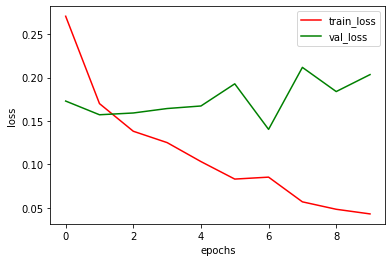

In [0]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
cnnLSTM_TweetModel = load_model('cnnLSTM_TweetModel.h5')

loss, acc = cnnLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = cnnLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)

1168/1168 [==============================] - 8s 7ms/step
dev evaluation: 0.14044635467333336  /  0.9443493150684932
779/779 [==============================] - 0s 172us/step
test evaluation: 0.1468290213462018  /  0.9358151476251605


---

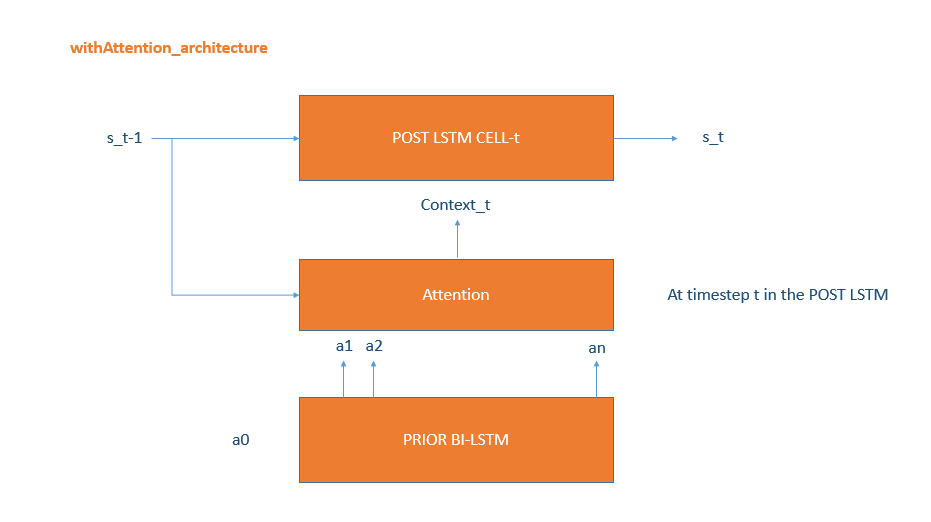

In [220]:
Image('withAttention_architecture.PNG')

In [29]:
#Global Layers
repeator = RepeatVector(MAXLEN)
concatenator = Concatenate(axis=-1)
densor = Dense(1, activation = "relu")
dot = Dot(axes = 1)

# Get context from prior activations / previous post activation
def get_context(a, s_prev):

  s_prev = repeator(s_prev)
  concat = concatenator([a, s_prev])
  e = densor(concat)
  e = Permute((2,1))(e)
  alphas = Activation('softmax')(e)
  alphas = Permute((2,1))(e)  
  context = dot([alphas, a])

  return context


n_a = 64
n_s = 128
POST_LSTM_cell = LSTM(n_s, return_state = True)  

In [0]:
#Architecture with (+/-) Attention layer
def WithAttention_TweetModel(n_a, n_l, DROPOUT, S_DROPOUT,  input_shape =  (25,)):
  
  sentence_ind = Input(shape = input_shape)  
  s0 = Input(shape=(n_s,), name='s0')
  c0 = Input(shape=(n_s,), name='c0')
  s = s0
  c = c0
  
  emb_layer = pretrained_emb()
  emb_layer = emb_layer(sentence_ind)
  emb_layer = SpatialDropout1D(S_DROPOUT)(emb_layer)

  prior = Bidirectional(CuDNNLSTM(n_a, return_sequences = True, name = 'PRIOR-LSTM'))(emb_layer)

  # ATTENTION LAYER
  for i in range(input_shape[0]):
    context = get_context(prior, s)
    s, _, c = POST_LSTM_cell(context, initial_state = [s, c])
  
  X = Dense(n_l, activation="relu")(s)  
  X = Dropout(DROPOUT)(X)    
  
  output = Dense(1, activation = "sigmoid", name = 'output')(X)  
  
  model = Model(inputs=[sentence_ind, s0, c0], outputs = output, name = "WithAttention_TweetModel")
  opt = adam(lr=0.001, decay = 0.0001)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])
  

  return model

In [0]:
withAttention_TweetModel = WithAttention_TweetModel(64, 32, 0.2, 0.2, (MAXLEN,))
withAttention_TweetModel.summary()

Model: "WithAttention_TweetModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 25, 100)      31703400    input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 25, 100)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 128)          0                                            
___________________________________________________________________________

In [0]:
ckpt = ModelCheckpoint('withAttention_TweetModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

s0_t = np.zeros((x_train.shape[0], n_s))
c0_t = np.zeros((x_train.shape[0], n_s))

s0_d = np.zeros((x_dev.shape[0], n_s))
c0_d = np.zeros((x_dev.shape[0], n_s))


history3 = withAttention_TweetModel.fit([x_train, s0, c0], Y_train, batch_size= 20, epochs = 10, validation_data=([x_dev, s0_d, c0_d] , Y_dev), callbacks = [ckpt], verbose = 1)

Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 56s 12ms/step - loss: 0.2385 - acc: 0.9016 - val_loss: 0.2393 - val_acc: 0.8938

Epoch 00001: val_loss improved from inf to 0.23927, saving model to withAttention_TweetModel.h5
Epoch 2/10
4543/4543 [==============================] - 31s 7ms/step - loss: 0.1821 - acc: 0.9238 - val_loss: 0.1628 - val_acc: 0.9307

Epoch 00002: val_loss improved from 0.23927 to 0.16284, saving model to withAttention_TweetModel.h5
Epoch 3/10
4543/4543 [==============================] - 31s 7ms/step - loss: 0.1602 - acc: 0.9329 - val_loss: 0.1535 - val_acc: 0.9264

Epoch 00003: val_loss improved from 0.16284 to 0.15350, saving model to withAttention_TweetModel.h5
Epoch 4/10
4543/4543 [==============================] - 31s 7ms/step - loss: 0.1387 - acc: 0.9423 - val_loss: 0.1622 - val_acc: 0.9298

Epoch 00004: val_loss did not improve from 0.15350
Epoch 5/10
4543/4543 [==============================] - 31s 

Text(0, 0.5, 'loss')

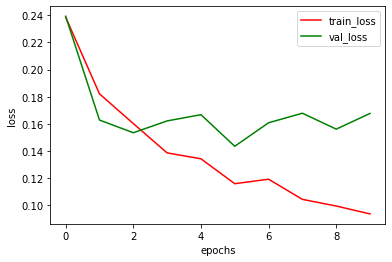

In [0]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
withAttention_TweetModel = load_model('withAttention_TweetModel.h5')
s0_ts = np.zeros((x_test.shape[0], n_s))
c0_ts = np.zeros((x_test.shape[0], n_s))

loss, acc = withAttention_TweetModel.evaluate([x_dev, s0_d, c0_d], Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = withAttention_TweetModel.evaluate([x_test, s0_ts, c0_ts], Y_test)
print('test evaluation:' , loss, ' / ',acc)

1168/1168 [==============================] - 9s 8ms/step
dev evaluation: 0.14354325642120347  /  0.9220890410958904
779/779 [==============================] - 1s 1ms/step
test evaluation: 0.1432203612217395  /  0.9332477535301669


---

Loss/Acc of the different models


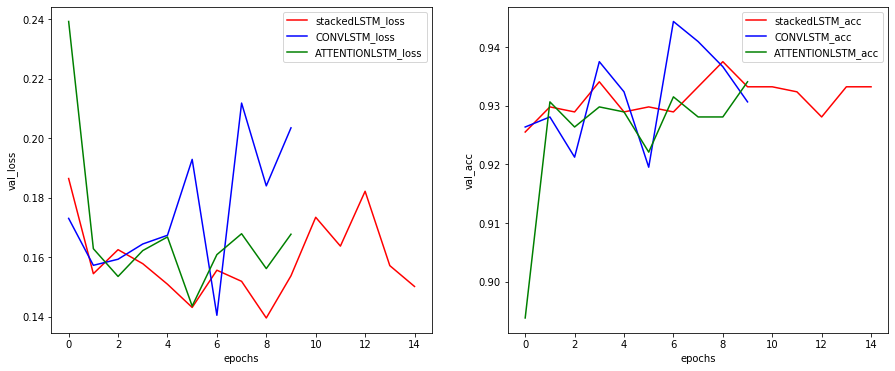

In [0]:
l1 = history1.history['val_loss']
l2 = history2.history['val_loss']
l3 = history3.history['val_loss']

acc1 = history1.history['val_acc']
acc2 = history2.history['val_acc']
acc3 = history3.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize = (6,6))
fig.set_size_inches(15,6)

print('Loss/Acc of the different models')

sns.lineplot(y= l1, x = np.arange(len(l1)), label = 'stackedLSTM_loss', color = 'r', ax= ax[0])
sns.lineplot(y= l2, x = np.arange(len(l2)), label = 'CONVLSTM_loss', color = 'b',  ax= ax[0])
sns.lineplot(y= l3, x = np.arange(len(l3)), label = 'ATTENTIONLSTM_loss', color = 'g', ax= ax[0])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('val_loss')

sns.lineplot(y= acc1, x = np.arange(len(acc1)), label = 'stackedLSTM_acc', color = 'r', ax= ax[1])
sns.lineplot(y= acc2, x = np.arange(len(acc2)), label = 'CONVLSTM_acc', color = 'b',  ax= ax[1])
sns.lineplot(y= acc3, x = np.arange(len(acc3)), label = 'ATTENTIONLSTM_acc', color = 'g', ax= ax[1])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('val_acc')

####  Ensembling
<a id="c36"></a>

In [0]:
#Ensembling
ypred0 = tweetModel.predict(test_tweets)
ypred1 = stackedLSTM_TweetModel.predict(test_tweets)
ypred2 = cnnLSTM_TweetModel.predict(test_tweets)

s0 = np.zeros((test_tweets.shape[0], n_s))
c0 = np.zeros((test_tweets.shape[0], n_s))
ypred3 = withAttention_TweetModel.predict([test_tweets, s0, c0])

ypred = (ypred1 + ypred2 + ypred3 + ypred0) / 4


Label = []
for ys in ypred:
  if ys > .5:
    Label.append("Sports")
  else:
    Label.append("Politics")
  
Label= pd.DataFrame(Label, columns=["Label"])
sub = pd.concat([test.TweetId, Label], axis = 1)
print(sub)

!rm sub.csv
sub.to_csv("sub.csv", index=False)
!kaggle competitions submit -c deeptweets -f sub.csv -m ""

                 TweetId     Label
0     306486520121012224    Sports
1     286353402605228032  Politics
2     289531046037438464  Politics
3     306451661403062273  Politics
4     297941800658812928    Sports
...                  ...       ...
2605  282023761044189184    Sports
2606  303879735006601216  Politics
2607  297956846046703616    Sports
2608  304265049537658880  Politics
2609  306430391928115200  Politics

[2610 rows x 2 columns]


Summary:



<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Dev_loss</th>
    <th>Test_loss</th>
    <th>Kaggle_accuracy</th>
  </tr>
  <tr>
    <td>Simple model</td>
    <td>0.1851</td>
    <td>0.2839</td>
    <td>----------</td>
  </tr>
  <tr>
    <td>Tuned Simple model</td>
    <td>----------</td>
    <td>0.1856</td>
    <td>0.8863</td>
  </tr>
  <tr>
    <td>Stacked LSTM model</td>
    <td>0.1395</td>
    <td>0.1636</td>
    <td>0.8966</td>
  </tr>
  <tr>  
    <td>CNN-LSTM model</td>
    <td>0.1405</td>
    <td>0.1468</td>
    <td>0.8914</td>
    
  </tr>
  <tr>  
    <td>withAttention model</td>
    <td>0.1436</td>
    <td>0.1432</td>
    <td>0.8531</td>
  </tr>
  <tr>  
    <td>Ensembling</td>
    <td>----------</td>
    <td>----------</td>
    <td>0.8940</td>
  </tr>  
</table>




#### Data augmentation
<a id="c37"></a>

Data augmentation is great way to unsure generalization and avoid overfitting.


We'll use the following:


*   Using synonyms/antonyms
*   Tf-idf
*   Cosine similarity
*   Most common words



In [31]:
# Synonym/antonyms dict using wordnet 

sim_dict = dict()

for w in progress_bar(vocab):  
  synonyms = []
  antonyms = []
  for syn in wordnet.synsets(w):
    for l in syn.lemmas():
      synm = l.name()      
      if synm in vocab and synm != w:
        synonyms.append(synm)
      if l.antonyms():
        ant = l.antonyms()[0].name()        
        if ant in vocab :
          antonyms.append(ant)
    synonyms.extend(antonyms)
    if len(synonyms) > 0:
      sim_dict[w] = set(synonyms)



In [32]:
# Generating similar sentences
def gen_similar(tweet, sim_dict, n = 5):
  tokens = getToken(tweet)  
  keys= sim_dict.keys()
  res = []  
  for token in tokens:    
    if token not in keys:
      continue
    sim = list(sim_dict[token])    
    for s in sim:      
      res.append(re.sub(token , s, tweet))
  if len(res) > n:
    sample = random.sample(res, n)
  else:
    sample = res

  return sample

gen_similar("obamacare would pay last year east classes people", sim_dict)

['obamacare would pay last year east classes citizenry',
 'obamacare would pay last year east family people',
 'obamacare would pay last year east class people',
 'obamacare would pay concluding year east classes people',
 'obamacare would pay last year east form people']

In [71]:
train_aug = train.loc[list(X_train.index)]

inds = train_aug.index
new_ind = inds.max() + 1

for i in tqdm(inds):    
  r = train_aug.loc[i, :]
  gen_sim = gen_similar(r.TweetText, sim_dict)  
  for gen in gen_sim:
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = gen, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1



100%|██████████| 4543/4543 [00:46<00:00, 86.10it/s]


In [79]:
# Adding new rows s.t low idf words are removed
vectorizer = TfidfVectorizer(vocabulary = vocab)
vectors = vectorizer.fit_transform(X_train.loc[:,1])

for i in tqdm(inds):    
  r = train_aug.loc[i, :]
  tokens = getToken(r.TweetText) 
  new_r = ''
  for token in tokens:    
    if token in vocab:      
      ind = vectorizer.vocabulary_[token]
      idf = vectorizer.idf_[ind]
      if idf <= 3:
        new_r = re.sub(token, '', r.TweetText)        
  if new_r != r.TweetText and len(new_r) > 0:            
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1


100%|██████████| 4543/4543 [01:18<00:00, 58.00it/s]


In [81]:
# Similar words using the cosine similarity on between the embedding vectors
def cos_sim(u, v):
  num = u.dot(v)
  denom = np.sqrt(np.sum(u ** 2)) * np.sqrt(np.sum(v ** 2))
  return num / denom

cos_sim(w2v['ball'], w2v['player'])

0.591834566192892

In [114]:
def most_sim(word, threshold = .7, n = 3):
  u = w2v[word]
  for w in vocab:
    if cos_sim(u, w2v[w]) >= threshold:
      return w  
  return word
most_sim('song')  

'music'

In [115]:
#e.g 
# given: i like this song
# append : i like this music
max_token_replace = 2
n_token_replace = 0

for i in progress_bar(inds):
  r = train_aug.loc[i,:]
  tokens = getToken(r.TweetText) 
  tokens = random.sample(tokens, len(tokens)) #shuffling the array
  new_r = ''  
  n_token_replace = 0
  for token in tokens:    
    if token in vocab:   
      replacement = most_sim(token)         
      if replacement != token:
        new_r = re.sub(token, replacement, r.TweetText)        
        n_token_replace += 1
        if n_token_replace == max_token_replace:
          break
  if new_r != r.TweetText  and len(new_r) > 0:                  
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1


In [116]:
# Adding new rows without low cosine-similarity with the corresponding label

max_token_rm = 2
token_rm = 0
for i in progress_bar(inds):
  r = train_aug.loc[i,:]
  tokens = getToken(r.TweetText) 
  tokens = random.sample(tokens, len(tokens)) #shuffling the array
  new_r = ''  
  token_rm = 0
  for token in tokens:    
    if token in vocab:            
      if cos_sim(w2v[token], w2v[r.Label.lower()]) < 0:
        new_r = re.sub(token, '', r.TweetText)        
        token_rm += 1
        if token_rm == max_token_rm:
          break
  if new_r != r.TweetText  and len(new_r) > 0:                  
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1


,TweetId,Label,TweetText
31995,data_aug,Sports,'#FL125 The total number of fans to have passe...
31996,data_aug,Politics,'India is one of the fastest expanding space m...
31997,data_aug,Sports,'COMPETITION: How many times does Ian Bell say...
31998,data_aug,Sports,James Pattinson makes a mess of M Vijay's . In...
31999,data_aug,Sports,"'For all those , Roger #Federer says thanks a ..."


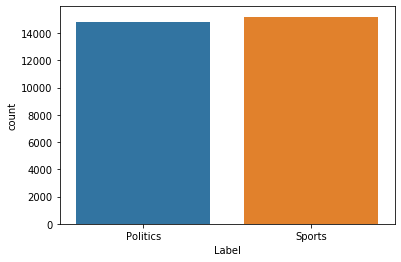

In [118]:
display(train_aug.tail())
sns.countplot(train_aug.Label)

In [120]:
x_train_aug = sentences2indice(np.array(train_aug.TweetText), w2i, vocab, MAXLEN)

lb = LabelEncoder().fit(train.Label)
Y_train_aug = lb.transform(train_aug.Label)

100%|██████████| 30019/30019 [57:41<00:00,  8.67it/s]

- 3461.1756694316864 seconds -


In [221]:
#Adding random sentences using the most common keywords
h_sports = []
h_politics = []
for i, r in tqdm(train.iterrows()):  
  tokens = getToken(r.TweetText)
  for token in tokens:        
    if r.Label == 'Sports':
      h_sports.append(token)
    else:
      h_politics.append(token)

common_sports = Counter(h_sports).most_common(40)
common_politics = Counter(h_politics).most_common(40)
print()
print('Sports # freq ',common_sports)
print('Politics # freq ',common_politics)

def generate_sentence(sport = True):
  i = random.randint(1,MAXLEN-1)
  sentence = ''
  if sport:
    for w, _ in random.sample(common_sports, i):
      sentence += w + ' '
  else:
    for w, _ in random.sample(common_politics, i):
      sentence += w + ' '

  return sentence
  
generate_sentence(sport = False)

6490it [00:03, 1712.43it/s]


Sports # freq  [('score', 575), ('rt', 406), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('win', 143), ('final', 142), ('first', 139), ('aus', 135), ('india', 133), ('game', 122), ('day', 119), ('team', 118), ('thanks', 107), ('great', 106), ('australia', 105), ('time', 105), ('one', 104), ('england', 103), ('cricket', 102), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
Politics # freq  [('president', 346), ('rt', 319), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 121), ('prime', 115), ('us', 114), ('nhttp', 113), ('today', 111)

'live medvedev u2019s meeting pm '

In [0]:
for _ in range(3000):
  sentence = generate_sentence()
  sentence = sentences2indice(np.array([sentence]), w2i, vocab, MAXLEN)
  x_train_aug = np.concatenate([x_train_aug, sentence])
  Y_train_aug = np.concatenate([Y_train_aug, np.array([1])])
  sentence = generate_sentence(sport = False)
  sentence = sentences2indice(np.array([sentence]), w2i, vocab, MAXLEN)
  x_train_aug = np.concatenate([x_train_aug, sentence])
  Y_train_aug = np.concatenate([Y_train_aug, np.array([0])])

#### Final evaluation
<a id="c38"></a>

In [191]:
stackedLSTM_TweetModel = StackedLSTM_TweetModel(64, 32, 0.5, 0.2, (MAXLEN,))
ckpt = ModelCheckpoint('stackedLSTM_TweetModel_aug.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
stackedLSTM_TweetModel.fit(x_train_aug, Y_train_aug, batch_size= 128, epochs = 15, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [ckpt])

Train on 38019 samples, validate on 1168 samples
Epoch 1/15
38019/38019 [==============================] - 39s 1ms/step - loss: 0.1902 - acc: 0.9250 - val_loss: 0.1566 - val_acc: 0.9307

Epoch 00001: val_loss improved from inf to 0.15662, saving model to stackedLSTM_TweetModel_aug.h5
Epoch 2/15
38019/38019 [==============================] - 4s 103us/step - loss: 0.1190 - acc: 0.9504 - val_loss: 0.1291 - val_acc: 0.9418

Epoch 00002: val_loss improved from 0.15662 to 0.12907, saving model to stackedLSTM_TweetModel_aug.h5
Epoch 3/15
38019/38019 [==============================] - 4s 106us/step - loss: 0.0937 - acc: 0.9610 - val_loss: 0.1404 - val_acc: 0.9418

Epoch 00003: val_loss did not improve from 0.12907
Epoch 4/15
38019/38019 [==============================] - 4s 102us/step - loss: 0.0798 - acc: 0.9661 - val_loss: 0.1474 - val_acc: 0.9375

Epoch 00004: val_loss did not improve from 0.12907
Epoch 5/15
38019/38019 [==============================] - 4s 104us/step - loss: 0.0627 - acc: 

In [192]:
stackedLSTM_TweetModel = load_model('stackedLSTM_TweetModel_aug.h5')

loss, acc = stackedLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = stackedLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 13s 11ms/step
dev evaluation: 0.12906984209197842  /  0.9417808219178082
779/779 [==============================] - 0s 162us/step
test evaluation: 0.15792801344960888  /  0.9345314509602352


In [193]:
cnnLSTM_TweetModel = CNNLSTM_TweetModel(64, 32, 0.5, 0.2, (MAXLEN,))

ckpt = ModelCheckpoint('CNNLSTM_TweetModel_aug.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
cnnLSTM_TweetModel.fit(x_train_aug, Y_train_aug, batch_size= 128, epochs = 15, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [ckpt])

Train on 38019 samples, validate on 1168 samples
Epoch 1/15
38019/38019 [==============================] - 39s 1ms/step - loss: 0.1556 - acc: 0.9358 - val_loss: 0.1364 - val_acc: 0.9401

Epoch 00001: val_loss improved from inf to 0.13639, saving model to CNNLSTM_TweetModel_aug.h5
Epoch 2/15
38019/38019 [==============================] - 3s 79us/step - loss: 0.0819 - acc: 0.9662 - val_loss: 0.1560 - val_acc: 0.9307

Epoch 00002: val_loss did not improve from 0.13639
Epoch 3/15
38019/38019 [==============================] - 3s 76us/step - loss: 0.0559 - acc: 0.9783 - val_loss: 0.1634 - val_acc: 0.9375

Epoch 00003: val_loss did not improve from 0.13639
Epoch 4/15
38019/38019 [==============================] - 3s 77us/step - loss: 0.0392 - acc: 0.9853 - val_loss: 0.1806 - val_acc: 0.9332

Epoch 00004: val_loss did not improve from 0.13639
Epoch 5/15
38019/38019 [==============================] - 3s 76us/step - loss: 0.0280 - acc: 0.9898 - val_loss: 0.2119 - val_acc: 0.9375

Epoch 00005: v

In [194]:
cnnLSTM_TweetModel = load_model('CNNLSTM_TweetModel_aug.h5')

loss, acc = cnnLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = cnnLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 13s 11ms/step
dev evaluation: 0.13638594960921432  /  0.940068493150685
779/779 [==============================] - 0s 114us/step
test evaluation: 0.15275779374144655  /  0.9409499361977192


In [195]:
withAttention_TweetModel = WithAttention_TweetModel(64, 32, 0.5, 0.2, (MAXLEN,))
ckpt = ModelCheckpoint('withAttention_TweetModel_aug.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

s0 = np.zeros((x_train_aug.shape[0], n_s))
c0 = np.zeros((x_train_aug.shape[0], n_s))

s0_d = np.zeros((x_dev.shape[0], n_s))
c0_d = np.zeros((x_dev.shape[0], n_s))


withAttention_TweetModel.fit([x_train_aug, s0, c0], Y_train_aug, batch_size= 128, epochs = 15, validation_data=([x_dev, s0_d, c0_d] , Y_dev), callbacks = [ckpt], verbose = 1)

Train on 38019 samples, validate on 1168 samples
Epoch 1/15
38019/38019 [==============================] - 89s 2ms/step - loss: 0.3005 - acc: 0.8659 - val_loss: 0.1884 - val_acc: 0.9212

Epoch 00001: val_loss improved from inf to 0.18843, saving model to withAttention_TweetModel_aug.h5
Epoch 2/15
38019/38019 [==============================] - 31s 817us/step - loss: 0.1702 - acc: 0.9309 - val_loss: 0.1586 - val_acc: 0.9349

Epoch 00002: val_loss improved from 0.18843 to 0.15857, saving model to withAttention_TweetModel_aug.h5
Epoch 3/15
38019/38019 [==============================] - 31s 819us/step - loss: 0.2450 - acc: 0.8939 - val_loss: 0.3362 - val_acc: 0.8596

Epoch 00003: val_loss did not improve from 0.15857
Epoch 4/15
38019/38019 [==============================] - 31s 812us/step - loss: 0.2627 - acc: 0.8962 - val_loss: 0.2223 - val_acc: 0.9118

Epoch 00004: val_loss did not improve from 0.15857
Epoch 5/15
38019/38019 [==============================] - 31s 811us/step - loss: 0.2187

In [196]:
withAttention_TweetModel = load_model('withAttention_TweetModel_aug.h5')

s0 = np.zeros((x_dev.shape[0], n_s))
c0 = np.zeros((x_dev.shape[0], n_s))
loss, acc = withAttention_TweetModel.evaluate([x_dev, s0, c0], Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
s0 = np.zeros((x_test.shape[0], n_s))
c0 = np.zeros((x_test.shape[0], n_s))
loss, acc = withAttention_TweetModel.evaluate([x_test, s0, c0], Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 19s 16ms/step
dev evaluation: 0.1585734976481085  /  0.934931506849315
779/779 [==============================] - 1s 975us/step
test evaluation: 0.16665589526314792  /  0.9345314505011494


,1,Label,predLabel
0,,,
6129,@madmanweb that's what I laughed !,Politics,Sports
3055,'@SAMI_hadyh thanks.',Politics,Sports
2537,'@arjunallhere used to be mine too !',Politics,Sports
1044,'@aGaInStcOmMuNaL thank you :)',Politics,Sports
3239,'@amithbn what are you talking about',Politics,Sports
...,...,...,...
4869,'@MohsinSayeed :-) ok will add you on FB though barely use it myself these days !',Politics,Sports
4273,'RT @lpolgreen: The Onion rightly apologizes for an incredibly crude tweet about a 9-year-old girl who happens to be a movie star. http:/ ...',Politics,Sports
5979,"You can rib us Punjabis all you want, but without our language you'd miss out some great music. From Bulleh Shah to Bolly jigs :-)",Politics,Sports


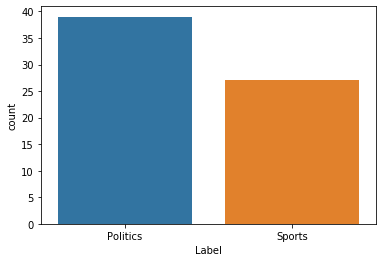

In [198]:
ypred1 = stackedLSTM_TweetModel.predict(x_dev)
ypred2 = cnnLSTM_TweetModel.predict(x_dev)

s0 = np.zeros((x_dev.shape[0], n_s))
c0 = np.zeros((x_dev.shape[0], n_s))
ypred3 = withAttention_TweetModel.predict([x_dev, s0, c0])

ypred = (ypred1 + ypred2 + ypred3) / 3

label = []

for y in ypred:
  if y > .5:
    label.append("Sports")
  else:
    label.append("Politics") 

label= pd.DataFrame(label, index = X_dev.index, columns=["predLabel"])
y_dev = pd.Series(lb.inverse_transform(Y_dev.astype(int)), name = 'Label', index = X_dev.index)
res = pd.concat([X_dev,  y_dev, label], axis=1)
res = res.loc[res.predLabel != res.Label]
pd.set_option('display.max_colwidth', -1)

display(res)
sns.countplot(res.Label)


This is great the models performs now better on sports (recall the error analysis previously)

Now let's compare the performance of our model to human(myself) performance

In [0]:
# Ensembling over the test data
ypred1 = stackedLSTM_TweetModel.predict(x_test)
ypred2 = cnnLSTM_TweetModel.predict(x_test)

s0 = np.zeros((x_test.shape[0], n_s))
c0 = np.zeros((x_test.shape[0], n_s))
ypred3 = withAttention_TweetModel.predict([x_test, s0, c0])

ypred = (ypred1 + ypred2 + ypred3) / 3

label = []

for y in ypred:
  if y > .5:
    label.append(1)
  else:
    label.append(0) 


In [216]:
human_test = pd.read_excel('humanLabeledX_test1.xlsx', index_col=0, header= None)
print('models f1 score: ',f1_score(Y_test[:100], label[:100]))
print('Human f1 score: ',f1_score(Y_test[:100], human_test[1]))

models f1 score:  0.9532710280373832
Human f1 score:  0.8679245283018869


This is proof that we are near the optimal/bayesian error, with that we are ready to submit the results

---


In [199]:
#Kaggle submission
ypred1 = stackedLSTM_TweetModel.predict(test_tweets)
ypred2 = cnnLSTM_TweetModel.predict(test_tweets)

s0 = np.zeros((test_tweets.shape[0], n_s))
c0 = np.zeros((test_tweets.shape[0], n_s))
ypred3 = withAttention_TweetModel.predict([test_tweets, s0, c0])

ypred = (ypred1 + ypred2 + ypred3) / 3


Label = []
for ys in ypred:
  if ys > .5:
    Label.append("Sports")
  else:
    Label.append("Politics")
  
Label= pd.DataFrame(Label, columns=["Label"])
sub = pd.concat([test.TweetId, Label], axis = 1)
print(sub)
!rm sub.csv
sub.to_csv("sub.csv", index=False)
!kaggle competitions submit -c deeptweets -f sub.csv -m ""

                 TweetId     Label
0     306486520121012224  Sports  
1     286353402605228032  Sports  
2     289531046037438464  Politics
3     306451661403062273  Politics
4     297941800658812928  Sports  
...                  ...     ...  
2605  282023761044189184  Sports  
2606  303879735006601216  Politics
2607  297956846046703616  Sports  
2608  304265049537658880  Politics
2609  306430391928115200  Politics

[2610 rows x 2 columns]
100% 67.4k/67.4k [00:01<00:00, 36.9kB/s]
Successfully submitted to DeepTweets

Results after augmentation of x_train:



<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Dev_loss</th>
    <th>Test_loss</th>
    <th>Kaggle_accuracy</th>
  </tr>    
  <tr>  
    <td>Stacked LSTM model</td>
    <td>0.1291</td>
    <td>0.1579</td>
    <td></td>
  </tr>
  <tr>    
    <td>CNN-LSTM model</td>
    <td>0.1364</td>
    <td>0.1528</td>
    <td></td>
    
  </tr>
  <tr>  
    <td>withAttention model</td>
    <td>0.1586</td>
    <td>0.1667</td>
    <td></td>
  </tr>
  <tr>  
    <td>Ensembling</td>
    <td>----------</td>
    <td>----------</td>
    <td>0.9004</td>
  </tr>
</table>




## 4 - Conclusion
<a id="c4"></a>

Conclusion and perspectives:


The results seems satisfying, but we could have explore more options:

*   Start with simpler machine learning approche: Naive bayes
*   Other preprocessing techniques (Lemmatization / better use of tf-idf)
*   Remove other non telling sentences from X_train (e.g '@rainaa102 Thank you')
*   More hyperparams fine-tuning 
*   Try GRUs
*   Transfert learning
*   Concatenatening different embedding + lstm (https://www.kaggle.com/shujian/blend-of-lstm-and-cnn-with-4-embeddings-1200d)
*   Dynamic word embedding BERT (https://medium.com/@adriensieg/from-pre-trained-word-embeddings-to-pre-trained-language-models-focus-on-bert-343815627598)

